In [ ]:
!pip install torch torchvision
!pip install datasets
!pip install transformers
!pip install --pre timm

In [1]:
from __future__ import print_function, division
import os
import torch
import timm
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam, AdamW

from datasets import Dataset
# from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import time
import copy
import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# CACHE_DIR = "./cache"
CELL_PAINTING_DIR = "/Users/cankoc/Coursework/cellvit"
BROAD_DIR = "/Users/cankoc/Coursework/cellpainting-gallery/cpg0019-moshkov-deepprofiler/broad"

In [3]:
class_labels_to_int = {
    'AKT1_E17K': 0,
    'AKT1_WT': 1,
    'BRAF_V600E': 2,
    'BRAF_WT': 3,
    'CDC42_Q61L': 4,
    'CDC42_T17N': 5,
    'CDC42_WT': 6,
    'EMPTY': 7,
    'KRAS_G12V': 8,
    'KRAS_WT': 9,
    'RAF1_L613V': 10,
    'RAF1_WT': 11,
    'RHOA_Q63L': 12,
    'RHOA_WT': 13
}
print(len(class_labels_to_int))

14


In [4]:
class CFG:
  data_dir = CELL_PAINTING_DIR + "/cache/small"
  debug = False
  n_gpu = 0
  device = "cpu" # ['cpu', 'mps']
  img_size = 224
  ### total # of classes in this dataset
  num_classes = len(class_labels_to_int)
  ### model
  model_name = 'maxvit_base_tf_224'
  pretrained=True
  batch_size = 64
  num_epochs = 30

  ### set only one to True
  save_best_loss = False
  save_best_accuracy = True

  optimizer = 'adamw' # ["rmsprop", "adam"]
  learning_rate = 5e-5
  adam_epsilon = 1e-6
  weight_decay = 0.1 # for adamw
  l2_penalty = 0.01 # for RMSprop
  rms_momentum = 0 # for RMSprop

  ### learning rate scheduler (LRS)
  scheduler = 'ReduceLROnPlateau' # []
  # scheduler = 'CosineAnnealingLR'
  plateau_factor = 0.5
  plateau_patience = 3
  cosine_T_max = 4
  cosine_eta_min = 1e-8
  verbose = True

  ### train and validation DataLoaders
  shuffle = True

  random_seed = 42

### Create a custom pytorch Dataset

In [5]:
from maxvit_dataset import MaxVitDataset

### Check to see if custom Dataset is working

In [6]:
training_data = MaxVitDataset(CFG, "train")
dev_data = MaxVitDataset(CFG, "dev")

In [7]:
print("Training and dev data sizes")
print(len(training_data))
print(len(dev_data))
print("Training and dev data at idx")
print(training_data[0][0].shape)
print(training_data[0][0].dtype)
print(training_data[0][0])
print(training_data[0][1])

Training and dev data sizes
2000
500
Training and dev data at idx
torch.Size([3, 224, 224])
torch.float32
tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0157, 0.0235],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0118, 0.0157],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0118],
         ...,
         [0.1059, 0.0980, 0.0902,  ..., 0.6235, 0.5569, 0.4745],
         [0.1176, 0.1137, 0.1059,  ..., 0.5765, 0.5137, 0.4392],
         [0.1255, 0.1216, 0.1137,  ..., 0.5176, 0.4588, 0.3961]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0157, 0.0235],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0118, 0.0157],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0118],
         ...,
         [0.1059, 0.0980, 0.0902,  ..., 0.6235, 0.5569, 0.4745],
         [0.1176, 0.1137, 0.1059,  ..., 0.5765, 0.5137, 0.4392],
         [0.1255, 0.1216, 0.1137,  ..., 0.5176, 0.4588, 0.3961]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0157, 0.0235],
         [0.0078,

In [8]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'dev': transforms.Compose([
#         transforms.CenterCrop(CFG.img_size),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# dataset = MaxVitBatchDataset(CFG,"train", transform=data_transforms["train"])
# sampler = torch.utils.data.BatchSampler(torch.utils.data.SequentialSampler(dataset),
#                                         batch_size=5,
#                                         drop_last=False)

# loader = torch.utils.data.DataLoader(dataset, sampler=sampler)
# for data in loader:
#     print(data)
#     break

### Inspect a subset of images

In [9]:
import random
from typing import List

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        title = f"class: {targ_label}"
        if display_shape:
            title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

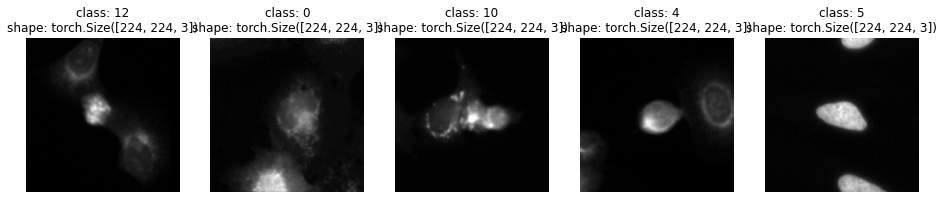

In [10]:
display_random_images(training_data, n=5)

### Fine Tuning With Timm

In [11]:
class MaxVitClassifier(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.model = timm.create_model(cfg.model_name, 
                                       pretrained=cfg.pretrained, 
                                       num_classes=cfg.num_classes)
        # n_features = self.model.head.in_features
        # self.model.head = nn.Linear(n_features, num_classes)
        # self.model.fc = nn.Linear(n_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'dev': transforms.Compose([
        transforms.CenterCrop(CFG.img_size),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: MaxVitDataset(CFG, split=x,
                                   transform=data_transforms[x])
                  for x in ['train', 'dev']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=CFG.batch_size,
                                              num_workers=20,
                                              shuffle=True)
              for x in ['train', 'dev']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}
# class_names = image_datasets['train'].classes
print(f"Dataset sizes: {dataset_sizes}")

device = torch.device("cuda:0" if torch.cuda.is_available() else CFG.device)
print(device)

Dataset sizes: {'train': 2000, 'dev': 500}
cpu


In [13]:
import random
def set_seed(cfg):
    random.seed(cfg.random_seed)
    np.random.seed(cfg.random_seed)
    torch.manual_seed(cfg.random_seed)
    if cfg.n_gpu > 0:
        torch.cuda.manual_seed_all(cfg.random_seed)

def train_model(cfg, model, dataloaders, criterion, optimizer):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(cfg.num_epochs):
        print('Epoch {}/{}'.format(epoch, cfg.num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'dev':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [14]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

set_seed(CFG)

model_ft = MaxVitClassifier(CFG)
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
# print("Params to learn:")

# for name,param in model_ft.named_parameters():
#     if param.requires_grad == True:
#             print("\t",name)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=5e-5, momentum=0.9)
optimizer_ft = AdamW(model_ft.parameters(), lr=CFG.learning_rate, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)

criterion = nn.CrossEntropyLoss()

In [15]:
model_ft, hist = train_model(CFG, model_ft, dataloaders, criterion, optimizer_ft)

Epoch 0/29
----------


 38%|███▊      | 12/32 [34:58<57:28, 172.43s/it]  